# Compute the mid Holocene temperature anomaly

This notebooks computes GMST using Generalized Additive Models (GAM). 

The main output is a netCDF file `annual-with-single-seas-gam-band-means.nc` with the temperature anomaly with reference to the 5000-3000 year BP period for the six latitudinal bands -90 to -60, -60 to -30, -30 to 0, 0 to 30, 30 to 60 and 60 to 90 degrees North.

This notebook is divided into three sections.

1. [Read the LiPD files](#lipds)
2. [Transform them into a combined dataframe](#pandas)
3. [Compute the grid cell anomalies](#cell-anomalies)

Note that you have to set the [version for the database](#db_version) manually.

## Strategy for modern reference value

- calculate PI anomaly of WorldClim period using 20CRv3
- Add PI anomaly to WorldClim (to retain high-res data)
- Add PI anomaly to SST data

For every sample:

- if  sample in PI: 
      use sample
- elif variableDetail == air@surface or lake@surface:
      if WorldClim has data at site:
          use WorldClim
      else:
          use closest worldClim
          send TSid to Basil
- else:
      if SST has data at site:
          use SST
      else:
          use closest SST
          send TSid to Basil

In [2]:
import pandas as pd
import numpy as np
import os.path as osp
import os
from urllib import request
import zipfile
import time
import pickle
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import warnings
import xarray as xr
import multiprocessing as mp
import psyplot.data as psyd
import gam_ensemble as ge
import pyleogrid as pg
from distributed import Client
import psyplot.project as psy
from matplotlib.animation import FuncAnimation
import contextlib
from sklearn.neighbors import BallTree
from latlon_utils import get_climate
from dask_jobqueue import SLURMCluster
import lipd

## Read the LiPD files <a name="lipds"></a>
In this section we read the temperature from the LiPD files. This involves some [filtering](#filter) to only keep the necessary temperature series. Note however, that samples with NaN are filtered [down below](#filter-nan).

<a id=db_version></a>Read in the LipD data from http://lipdverse.org/globalHolocene/current_version

You should set the latest version here manually!

In [3]:
%matplotlib inline

In [4]:
db_version = '1_0_0'

In [5]:
lipd_dir = f'../lipds_{db_version}'

In [6]:
output_dir = f'../output_{db_version}'
!mkdir -p {output_dir}

Download the LiPD file if the input directory does not yet exist

In [7]:
%%time
if not osp.exists(lipd_dir):
    os.makedirs(lipd_dir)
    zipped = f'Temp12k_v{db_version}_LiPD.zip'
    uri = f'https://www1.ncdc.noaa.gov/pub/data/paleo/reconstructions/climate12k/temperature/version{db_version.replace("_", ".")}/{zipped}'
    target = osp.join(lipd_dir, zipped)
    print('downloading ' + uri)
    request.urlretrieve(uri, target)
    with zipfile.ZipFile(target) as f:
        f.extractall(lipd_dir)

CPU times: user 741 µs, sys: 0 ns, total: 741 µs
Wall time: 764 µs


In [8]:
@contextlib.contextmanager
def remember_cwd():
    """Context manager to switch back to the current working directory

    Usage::

        with remember_cwd():
            os.chdir('test')
            print(os.getcwd())  # test
        print(os.getcwd())      # test/.."""
    curdir = os.getcwd()
    try:
        yield
    except:
        raise
    finally:
        os.chdir(curdir)

Load the data from the LiPD files it is has not yet been serialized as a pickled object.

In [9]:
%%time
pickle_file = f'{lipd_dir}/lipds.pkl'
if osp.exists(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
else:
    with remember_cwd():
        os.chdir(f'{lipd_dir}/')
        data = lipd.readLipd('.')
    with open(pickle_file, 'wb') as f:
        pickle.dump(data, f)

CPU times: user 177 ms, sys: 61.4 ms, total: 238 ms
Wall time: 267 ms


Extract the individual time-series from the LiPD files

In [10]:
%%time
all_series = lipd.extractTs(data)

extracting paleoData...
extracting: GodziszewskieLake.Miotk.1986
extracting: Hudson.Clegg.2011
extracting: ParkPond1.Lynch.1998
extracting: ElGygytgynCrater.Schwamborn.2006
extracting: Dalmutladdo.Bjune.2004
extracting: GeoB10043_3.Setiawan.2015
extracting: MD99_2341.Eynaud.2009
extracting: CN01.Cheung.2017
extracting: HumberPond5.McAndrews.1989
extracting: TauldintreBrazi.Toth.2015
extracting: LagunaSaladaChiprana.EPD
extracting: PrazRodet.Shotyk.1997
extracting: SaladaPequena.EPD
extracting: Leviathan.Lachniet.2014
extracting: BloodPond.Marsicek.2013
extracting: Khatanga-12Lake.Syrykh.2017
extracting: rainbow.Clegg.2011
extracting: M77_2_024_5.Salvatteci.2019
extracting: GeoB7926_2.Kim.2012
extracting: LagoMoreno.Markgraf.2002
extracting: PolandSpring.Jacobson.Ja
extracting: MSM05-712.Muller.2013
extracting: Gammelheimvatnet.Seppa.2009
extracting: WCA3BGumboLimboMarsh.Willard.2001
extracting: NussbaumerSeen.Rsch.1995
extracting: DevonIslandGlacier.McAndrews.1984
extracting: klotjarne

extracting: MSM05_5_712_2.Werner.2013
extracting: brurskardstjorni.Velle.2005
extracting: BattleGround.Whitlock.1985
extracting: Sokli.Shala.2017
extracting: LiivjarveBog.Koff.1989
extracting: GeoB4905_4.Weldeab.2005
extracting: Zabieniec.Plociennik.2011
extracting: Stazersee.Heiri.2015
extracting: D13882.Tierney
extracting: Frozen.Rosenberg.2004
extracting: PupukeChironomid.VandenBos.2018
extracting: GYXO.Self.2015
extracting: BebrukasLake.Shulija.1967
extracting: MD03_2699.Rodrigues.2010
extracting: LittleLochRoag.Birks.1979
extracting: Haugtjern.Eide.2009
extracting: PC_1.Chang.2015
extracting: EDML.Stenni.2010
extracting: PlateauRemote.MosleyThompson.1996
extracting: B997_324.Castaneda.2004
extracting: M77_2_003_2.Salvatteci.2019
extracting: KNR195_5_CDH23.Bova.2015
extracting: MD79_257.Bard.1997
extracting: Decoy.Szeicz.1991
extracting: MD95_2011.Risebrobakken.2003
extracting: Ennadai-2.Nichols.1975
extracting: Gemini.Samartin.2017
extracting: Ladd.Shane.1993
extracting: Demont.Ka

extracting: AMP112.vanderBilt.2016
extracting: B997_321.Castaneda.2004
extracting: Berry.Whitehead.1979
extracting: RC27_28.Overpeck.1996
extracting: Basse-Ville.Voeltzel.1987
extracting: LB1.Gajewski.1993
extracting: ODP658C_UK37.Zhao.1995
extracting: BN7Lake.Gajewski.1991
extracting: LagoVerdarolo.Samartin.2011
extracting: Ennadai-1.Nichols.1967
extracting: MD01_2412.Harada.2006
extracting: LagodeAjo.Allen.1996
extracting: Donvold.Nilssen.1983
extracting: GreyIslands.Cullen.2002
extracting: TanaLake.Loomis.2015
extracting: MD95_2015.Marchal.2002
extracting: LeFourneau.Barbier.1999
extracting: 165_1002C.Herbert.2000
extracting: GIK17049_6.Jung.1996
extracting: 31Lake.Eisner.1995
extracting: OregonCaves.Ersek.2012
extracting: MD02_2503.Hill.2006
extracting: VuolepNjakajaure.Heinrichs.2006
extracting: GeoB9310_4.Weldeab.2014
extracting: ODP_167_1019C.Barron.2003
extracting: JR01.Fortin.2017
extracting: Hams.Bennett.1987
extracting: Ostrowite.Milecka.2002
extracting: StaroselskyMoch.Nove

Filter all the series to extract the calibrated temperature series <a name="filter"></a>

In [11]:
filtered_ts_temp12k = lipd.filterTs(all_series,'paleoData_inCompilation == Temp12k')
temperatures = lipd.filterTs(filtered_ts_temp12k,'paleoData_units == degC')

Found 1319 matches from 5088 columns
Found 1276 matches from 1319 columns


## Conversion to pandas
Now that we have the time-series, we transform them to a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). This allows us to use groupby and other database measures.

For this purpose, we first define a few meta data attributes that should be kept for every record.

- `meta_cols` is the attribute in the dictionary of the individual time series. If the attribute is within a key or list, you can separate them by a single `.`. 
  
  `paleoData_interpretation.0.seasonalityGeneral` 
  
  for instance will be interpreted as
  
  `d['paleoData_interpretation'][0]['seasonalityGeneral']`
- `meta_names` is the name of the corresponding attribute in `meta_cols` how it should be saved in the dataframe

In [12]:
meta_cols = ['geo_meanLon', 'geo_meanLat', 'dataSetName', 'paleoData_variableName', 'paleoData_TSid', 
             'paleoData_interpretation.0.seasonalityGeneral', 'paleoData_interpretation.0.variableDetail',
             'paleoData_datum', 'paleoData_proxy']
meta_names = ['lon', 'lat', 'dataSetName', 'variableName', 'TSid', 'seasonality', 'variableDetail', 
              'datum', 'proxy']

Then every dictionary in `temperatures` is converted to a pandas datafram

In [13]:
frames = []
failures = []
for d in pg.utils.log_progress(temperatures):
    if 'age' in d:
        try:
            s = pd.Series(
                np.asarray(d['paleoData_values'], dtype=float),
                index=pd.Index(np.asarray(d['age'], dtype=float), name='age'),
                name='temperature')
        except ValueError:
            failures.append(d)
        else:
            # keep NaN of ages, these are filtered out later
            s = s[(~np.isnan(s.index)) & (s.index > -70 ) & (s.index < 14000)]
            # if the time series has (in average) more than one sample per
            # decade, we use decadal averages
            if s.size > 1470:
                s = s.groupby(lambda i: 5 + i - (i % 10)).mean()
                s.index.name = 'age'
            s.index.name = 'age'
            frame = s.to_frame().reset_index()
            for i, name in enumerate(meta_cols):
                sub = d
                vals = name.split('.')
                name = vals[-1]
                for v in vals[:-1]:
                    sub = sub[v if isinstance(sub, dict) else int(v)]
                frame[meta_names[i]] = sub.get(name, np.nan)
            frames.append(frame)
print(f"Failed to read {len(failures)} time series")

Starting at 2020-04-30 15:25:18.152132
|████████████████████████████████████████████████████████████████████████████████| 100.0% Time left: 0.000 minutes
Finished at 2020-04-30 15:25:24.052136. Time needed: 0.098 minutes
Failed to read 0 time series


Now we concatenate everything into one large dataframe

In [14]:
df = pd.concat(frames, ignore_index=True)
df.head()

,age,temperature,lon,lat,dataSetName,variableName,TSid,seasonality,variableDetail,datum,proxy
0,212.13,-2.045714,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,pollen
1,275.05,-4.110000,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,pollen
2,337.83,-3.375714,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,pollen
3,427.04,-2.907143,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,pollen
4,515.32,-4.094286,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,pollen


### Estimation of uncertainties

The age uncertainty is estimated such, that it is 50 years at 0 BP and 250 years at 12k BP

In [15]:
df['age_unc'] = 50 + df.age * (250 - 50) / 12000

The temperature uncertainty is estimated per proxy and per season <a name="temp-unc"></a>

In [16]:
uncertainties = pd.read_excel(
    '../data/proxy-uncertainties.xlsx', sheet_name='Summary', 
    index_col='proxy', usecols=[0, 1, 2, 3])
uncertainties

,summer,winter,annual
proxy,,,
pollen,2.017837,3.012946,2.105745
other microfossils/dinocyst,1.700000,1.200000,1.200000
chironomid,1.399705,NaN,NaN
other microfossils/diatoms,1.122375,NaN,NaN
other microfossils/radiolaria,1.200000,NaN,NaN
other microfossils/foraminifera,1.325000,1.412500,1.282500
alkenone,NaN,NaN,1.650000
MgCa,1.850000,1.850000,1.850000
GDGT (MBT/CBT as well as BrGDGT fractional abundance),NaN,NaN,2.902857


In [17]:
uncertainty_map = {
    'dinocyst': 'other microfossils/dinocyst',
    'pollen': 'pollen', 
    'chironomid': 'chironomid',
    'alkenone': 'alkenone',
    'GDGT': 'GDGT (MBT/CBT as well as BrGDGT fractional abundance)',
    'Mg/Ca': 'MgCa',
    'macrofossils': 'macrofossils',
    'bubble frequency': 'bubble frequency',
    'borehole': 'borehole',
    'C15 fatty alcohols': 'C15 fatty alcohols',
    'd18O': 'd18O',
    'radiolaria': 'other microfossils/radiolaria',
    'foraminifera': 'other microfossils/foraminifera',
    'dD': 'dD',
    'd13C': 'd13C',
    'diatom': 'other microfossils/diatoms',
    'isotope diffusion': 'isotope diffusion',
    'TRW': 'TRW',
    'hybrid-ice': 'hybrid-ice',
    'deterium excess': 'deterium excess',
    'gas': 'gas',
    'chlorophyll': 'chlorophyll',
    'melt layer': 'melt layer',
    '3-OH-Fatty Acids': '3-OH-Fatty Acids',
    'TEX86': 'GDGT (Tex86)',
    'LDI': 'LDI',
    'long chain diol': 'long chain diol'
}
uncertainty_map_inv = {val: key for key, val in uncertainty_map.items()}

In [18]:
df['seas'] = np.nan
seasonality = df.seasonality.fillna('')
df.loc[seasonality.str.startswith('summer'), 'seas'] = 'summer'
df.loc[seasonality.str.startswith('winter'), 'seas'] = 'winter'
df.loc[seasonality.str.startswith('annual'), 'seas'] = 'annual'

In [19]:
last = uncertainties.isnull().all(axis=1)
uncertainties = uncertainties.iloc[:np.argmax(last.values)]
# default uncertainty: 75th percentile of all values without d18O
df['temp_unc'] = 1.975877719
for proxy, row in uncertainties.iterrows():
    for seas, val in row[row.notnull().values].items():
        mask = (df.proxy == uncertainty_map_inv[proxy]) & (df.seas == seas)
        df.loc[mask.values, 'temp_unc'] = val

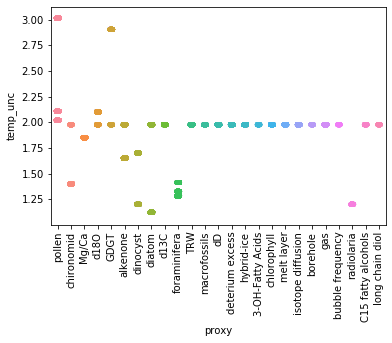

In [20]:
import seaborn as sns
ax = sns.stripplot('proxy', 'temp_unc', data=df)
for t in ax.get_xticklabels():
    t.set_rotation(90)

Now we filter out samples that have unrealistic temperatures, or no seasonality <a name="filter-nan"></a>.

In [21]:
df.loc[~df.temperature.between(-200, 200).values, 'temperature'] = np.nan

## Merge climate information

In [22]:
with psyd.open_dataset('../data/equal-area-grid-N4000.nc') as _ds:
    output_ds = _ds.load()

In [23]:
worldclim_input = '/gpfs/work/sommerp/worldclim/tavg_30s.1850-1899.nc'

In [24]:
%%time
air_mask = df.variableDetail.isin(['air@surface', 'lake@surface'])
coords = df[air_mask].drop_duplicates(['lat', 'lon', 'TSid'])[['lat', 'lon', 'TSid']]

tavg = get_climate(coords.lat.values, coords.lon.values, ['tavg'], 
                   data_files=[worldclim_input])
missing_tavg = tavg.isnull().values.any(axis=1)

print("Datasets without tavg:", missing_tavg.sum())

tavg.loc[missing_tavg, :] = get_climate(
    coords.lat.values[missing_tavg], coords.lon.values[missing_tavg],
    ['tavg'], data_files=[worldclim_input], radius=100)
tavg[('tavg', 'missing')] = False
tavg.loc[missing_tavg, ('tavg', 'missing')] = True

still_missing_tavg = tavg.isnull().values.any(axis=1)

climate = coords.merge(tavg.reset_index(), on=['lat', 'lon'], how='left')

print("Still missing with radius 100:", still_missing_tavg.sum())

Datasets without tavg: 16
Still missing with radius 100: 1
CPU times: user 6.59 s, sys: 1.55 s, total: 8.13 s
Wall time: 42.3 s


/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [25]:
sst_input = '../external/sst.mon.mean.ltm.1971-2000.nc'

In [26]:
%%time
sst_mask = df.variableDetail.isin(['sea@surface', 'sea@subsurface'])
coords = df[sst_mask].drop_duplicates(['lat', 'lon'])[['lat', 'lon', 'TSid']]

sst = get_climate(coords.lat.values, coords.lon.values, ['sst'], 
                   data_files=[sst_input])
missing_sst = sst.isnull().values.any(axis=1)

print("Datasets without sst:", missing_sst.sum())

sst.loc[missing_sst, :] = get_climate(
    coords.lat.values[missing_sst], coords.lon.values[missing_sst],
    ['sst'], data_files=[sst_input], radius=1)
sst[('sst', 'missing')] = False
sst.loc[missing_sst, ('sst', 'missing')] = True

still_missing_sst = sst.isnull().values.any(axis=1)

print("Still missing with radius 100:", still_missing_sst.sum())

sst.columns = tavg.columns

climate = pd.concat(
    [climate, coords.merge(sst.reset_index(), on=['lat', 'lon'], how='left')])

Datasets without sst: 3
Still missing with radius 100: 0
CPU times: user 1.38 s, sys: 1.96 s, total: 3.34 s
Wall time: 3.48 s


In [27]:
climate_renamed = climate.copy()
climate_renamed.columns = list(climate.columns[:3]) + list(map(
    '_'.join, climate.columns[3:].values))

df = df.merge(climate_renamed.drop(['lat', 'lon'], 1), on='TSid', how='left')
df.head()

,age,temperature,lon,lat,dataSetName,variableName,TSid,seasonality,variableDetail,datum,...,tavg_sep,tavg_oct,tavg_nov,tavg_dec,tavg_djf,tavg_mam,tavg_jja,tavg_son,tavg_ann,tavg_missing
0,212.13,-2.045714,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,...,13.757172,9.057172,3.757172,0.757172,-0.609495,7.757172,17.157172,8.857172,8.290505,False
1,212.13,-2.045714,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,...,13.757172,9.057172,3.757172,0.757172,-0.609495,7.757172,17.157172,8.857172,8.290505,False
2,212.13,-2.045714,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,...,13.757172,9.057172,3.757172,0.757172,-0.609495,7.757172,17.157172,8.857172,8.290505,False
3,275.05,-4.110000,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,...,13.757172,9.057172,3.757172,0.757172,-0.609495,7.757172,17.157172,8.857172,8.290505,False
4,275.05,-4.110000,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,...,13.757172,9.057172,3.757172,0.757172,-0.609495,7.757172,17.157172,8.857172,8.290505,False


In [28]:
df['modern'] = np.nan
df['seas'] = ''
for seas, months in [
        ('winter', 'djf'), 
        ('summer', 'jja'), 
        ('annual', 'ann')]:
    mask = df.seasonality.str.lower().str.startswith(seas) & df.seasonality.notnull()
    df.loc[mask.values, 'modern'] = df.loc[mask.values, 'tavg_' + months]
    df.loc[mask.values, 'seas'] = seas

## Recalculate necessary series

In [29]:
recalc = {}
reject = []
for key, row in df.loc[
        (df.variableName == 'temperatureComposite') &
        (df.seas == 'annual') & (df.datum.notnull())].drop_duplicates('TSid').iterrows():
    reject.append(row.TSid)
    others = df[df.dataSetName == row.dataSetName].drop_duplicates('TSid')
    if len(others) < 3:
        continue
    summer = others[(others.seas == 'summer') & (others.proxy == row.proxy)]
    winter = others[(others.seas == 'winter') & (others.proxy == row.proxy)]
    if (len(summer) == 1 and len(winter) == 1 and 
            summer.datum.values[0] == winter.datum.values[0]):
        recalc[row.TSid] = list(summer.TSid) + list(winter.TSid)
recalc

{'RSvtIc0N66Y': ['PYTCLN8P1CL', 'PYTMLFNC0A7'],
 'RiqkBNqHL3T': ['RiOf362hfE8', 'RBFjUCSs1ez'],
 'Rp2JYWaTx52': ['RLWjHSdRtHs', 'RtpMcgORKEU'],
 'RGBciJa69Zj': ['R9MShz9HNQ2', 'R4leNyaMf2O'],
 'Rfe0do1gMXq': ['Rp1oVLUaXiR', 'RLlDtgL9a38'],
 'RO0fn3HkrCf': ['RUSsCExepnT', 'R4IqlneHg0B'],
 'RIlNg5PrONi': ['WEB19eac4d9', 'PYTN6TJY4W2'],
 'RxPYP3y92HP': ['RmkH7bJsTt4', 'RR7iIYb69dm'],
 'RGoGCWU3ZCt': ['RiB0APxe8nT', 'RiFf6Q0GKhT']}

In [30]:
df['recalculated'] = False

In [31]:
rejected_datasets = df[df.TSid.isin(reject)].dataSetName.unique()
datasets_with_rejection = df[df.dataSetName.isin(rejected_datasets)].drop_duplicates('TSid')
datasets_with_rejection.sort_values(['dataSetName', 'seas'], inplace=True)
datasets_with_rejection['rejected'] = datasets_with_rejection.TSid.isin(reject)
datasets_with_rejection['recalculated'] = datasets_with_rejection.TSid.isin(recalc)
datasets_with_rejection.drop(
    ['age', 'age_unc', 'modern', 'temp_unc', 'temperature'] + 
    [col for col in datasets_with_rejection.columns
     if col.startswith('tavg')], axis=1, inplace=True)
datasets_with_rejection.to_excel(f'{output_dir}/rejected_series.xlsx')
datasets_with_rejection

,lon,lat,dataSetName,variableName,TSid,seasonality,variableDetail,datum,proxy,seas,recalculated,rejected
27167,-128.0800,64.6500,Andy.Szeicz.1995,temperatureComposite,RSvtIc0N66Y,annual,air@surface,anom,pollen,annual,True,True
27014,-128.0800,64.6500,Andy.Szeicz.1995,temperature,PYTCLN8P1CL,summerOnly,air@surface,anom,pollen,summer,False,False
26843,-128.0800,64.6500,Andy.Szeicz.1995,temperature,PYTMLFNC0A7,winterOnly,air@surface,anom,pollen,winter,False,False
134235,-58.0365,61.4639,CC04.Gibb.2015,temperatureComposite,RxPYP3y92HP,annual,sea@surface,anom,dinocyst,annual,True,True
134110,-58.0365,61.4639,CC04.Gibb.2015,temperature,RmkH7bJsTt4,summer+,sea@surface,abs,dinocyst,summer,False,False
133985,-58.0365,61.4639,CC04.Gibb.2015,temperature,RR7iIYb69dm,winter+,sea@surface,abs,dinocyst,winter,False,False
225179,-130.6500,61.6800,CandelabraLake.Cwynar.1995,temperatureComposite,RAll4J7F1rY,annual,air@surface,anom,pollen,annual,False,True
224843,-130.6500,61.6800,CandelabraLake.Cwynar.1995,temperature,PYT17LJ7OZ8,summer+,air@surface,abs,pollen,summer,False,False
225011,-130.6500,61.6800,CandelabraLake.Cwynar.1995,temperature,WEBbc9e627b,winter+,air@surface,NaN,pollen,winter,False,False
1487,20.7200,69.1700,Dalmutladdo.Bjune.2004,temperatureComposite,RJ46xwfMboE,annual,air@surface,anom,pollen,annual,False,True


In [32]:
rejected_data = df[df.TSid.isin(reject)]
df = df[~df.TSid.isin(reject)]
print("Dropped %i records of %i time-series" % (
    len(rejected_data), len(rejected_data.TSid.unique())))

Dropped 4227 records of 18 time-series


In [33]:
recalculated_data = []

for target, ids in recalc.items():
    ids_data = df.drop_duplicates(['age', 'TSid']).set_index('TSid').loc[ids]
    
    ids_ann = ids_data.pivot('age', 'seas', 'temperature').interpolate(
        method='linear').mean(axis=1).rename('temperature').to_frame()
    ids_ann['modern'] = np.mean(ids_data.modern.unique())
    ids_ann['TSid'] = target
    ids_ann['seasonality'] = 'annual'
    ids_ann['seas'] = 'annual'
    ids_ann['variableName'] = 'temperatureComposite2'
    # merge age uncertainties
    ids_ann = ids_ann.merge(
        ids_data.pivot('age', 'seas', 'age_unc').interpolate(
            method='linear').mean(axis=1).rename('age_unc'),
        on='age')
    # merge temperature uncertainties
    ids_ann = ids_ann.merge(
        ids_data.pivot('age', 'seas', 'temp_unc').interpolate(
            method='linear').mean(axis=1).rename('temp_unc'),
        on='age').reset_index()
    # merge the rest
    for col in [col for col in ids_data.columns if col not in ids_ann.columns]:
        ids_ann[col] = ids_data.iloc[0][col]
    ids_ann['recalculated'] = True
    recalculated_data.append(ids_ann)
print("Appending %s records" % sum(map(len, recalculated_data)))
df = pd.concat([df] + recalculated_data, ignore_index=True, sort=False)

Appending 1193 records


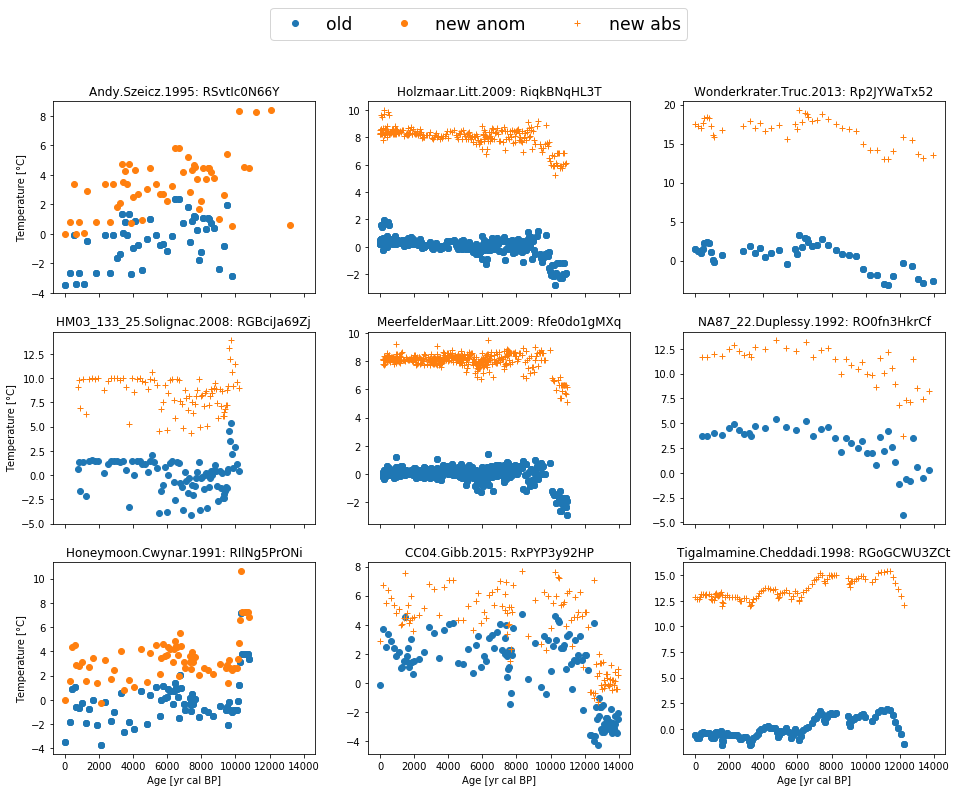

In [34]:
axes = psy.multiple_subplots(3, 3, n=len(recalc), sharex=True)

artists = {}

for tsid, ax in zip(recalc, axes):
    old = rejected_data[rejected_data.TSid == tsid]
    new = df[df.TSid == tsid]
    new_marker = '+' if new.iloc[0].datum == 'abs' else 'o'
    new_label = 'new abs' if new.iloc[0].datum == 'abs' else 'new anom'
    ax.set_title(f"{new.iloc[0].dataSetName}: {tsid}")
    old_points = ax.plot(old.age, old.temperature, 'o', label='old')[0]
    new_points = ax.plot(new.age, new.temperature, new_marker, label='new')[0]
    
    artists['old'] = old_points
    artists[new_label] = new_points
    
    if ax.rowNum == 2:
        ax.set_xlabel('Age [yr cal BP]')
    if ax.colNum == 0:
        ax.set_ylabel('Temperature [°C]')
    
for fig in set(ax.figure for ax in axes):
    fig.legend(list(artists.values()), list(artists),
               ncol=3, loc='upper center', fontsize='xx-large')

In [35]:
for col in ['seasonality', 'datum', 'temperature', 'age', 'modern']:
    print(f'NaN for {col}: {df[col].isnull().sum()}')

NaN for seasonality: 0
NaN for datum: 19295
NaN for temperature: 17306
NaN for age: 0
NaN for modern: 19953


In [50]:
df[df.TSid == 'WEB911b3b41']

,age,temperature,lon,lat,dataSetName,variableName,TSid,seasonality,variableDetail,datum,...,tavg_nov,tavg_dec,tavg_djf,tavg_mam,tavg_jja,tavg_son,tavg_ann,tavg_missing,modern,recalculated
52191,-57.0,-0.15,-58.96,-62.221,Yanou.Foster.2016,temperature,WEB911b3b41,summerOnly,air@surface,abs,...,0.05968,1.45968,2.026347,-1.506986,-6.04032,-1.94032,-1.86532,False,-6.04032,False
52192,268.0,2.16,-58.96,-62.221,Yanou.Foster.2016,temperature,WEB911b3b41,summerOnly,air@surface,abs,...,0.05968,1.45968,2.026347,-1.506986,-6.04032,-1.94032,-1.86532,False,-6.04032,False
52193,431.0,1.57,-58.96,-62.221,Yanou.Foster.2016,temperature,WEB911b3b41,summerOnly,air@surface,abs,...,0.05968,1.45968,2.026347,-1.506986,-6.04032,-1.94032,-1.86532,False,-6.04032,False
52194,593.0,1.49,-58.96,-62.221,Yanou.Foster.2016,temperature,WEB911b3b41,summerOnly,air@surface,abs,...,0.05968,1.45968,2.026347,-1.506986,-6.04032,-1.94032,-1.86532,False,-6.04032,False
52195,755.0,4.18,-58.96,-62.221,Yanou.Foster.2016,temperature,WEB911b3b41,summerOnly,air@surface,abs,...,0.05968,1.45968,2.026347,-1.506986,-6.04032,-1.94032,-1.86532,False,-6.04032,False
52196,877.0,0.47,-58.96,-62.221,Yanou.Foster.2016,temperature,WEB911b3b41,summerOnly,air@surface,abs,...,0.05968,1.45968,2.026347,-1.506986,-6.04032,-1.94032,-1.86532,False,-6.04032,False
52197,998.0,0.97,-58.96,-62.221,Yanou.Foster.2016,temperature,WEB911b3b41,summerOnly,air@surface,abs,...,0.05968,1.45968,2.026347,-1.506986,-6.04032,-1.94032,-1.86532,False,-6.04032,False
52198,1119.0,6.35,-58.96,-62.221,Yanou.Foster.2016,temperature,WEB911b3b41,summerOnly,air@surface,abs,...,0.05968,1.45968,2.026347,-1.506986,-6.04032,-1.94032,-1.86532,False,-6.04032,False
52199,1241.0,4.34,-58.96,-62.221,Yanou.Foster.2016,temperature,WEB911b3b41,summerOnly,air@surface,abs,...,0.05968,1.45968,2.026347,-1.506986,-6.04032,-1.94032,-1.86532,False,-6.04032,False
52200,1362.0,4.37,-58.96,-62.221,Yanou.Foster.2016,temperature,WEB911b3b41,summerOnly,air@surface,abs,...,0.05968,1.45968,2.026347,-1.506986,-6.04032,-1.94032,-1.86532,False,-6.04032,False


In [36]:
print(df.shape)
df.dropna(subset=['seasonality', 'datum', 'temperature', 'age', 'modern'], 
          inplace=True)
print(df.shape)

(223285, 34)
(171436, 34)


In [37]:
df.TSid.unique().size

1066

In [38]:
with psyd.open_dataset('../data/equal-area-grid-N4000.nc') as _ds:
    output_ds = _ds.load()
area = output_ds['cell_area']
output_ds['time'] = time = xr.Variable(
    ('time', ), np.arange(12000, -50, -100),
    attrs = {'long_name': 'Age', 'units': 'years since 1950-01-01'})
output_ds['temperature'] = xr.Variable(
    ('time', area.dims[0]), np.full((time.size, area.size), np.nan),
    encoding = dict(coordinates='clat clon'))

ensemble = ge.GAMEnsemble(
    df[(df.seasonality == 'annual') | 
       (df.seasonality == 'summerOnly') | 
       (df.seasonality == 'winterOnly')].set_index('age'), 
    target=output_ds.psy['temperature'],
    climate='temperature', ds_id='TSid')

In [ ]:
raise ValueError("Check whether summerOnly is actually correct!!")

In [38]:
%%time
ds = ensemble.input_data
ages = ensemble.sample_ages(size=1000, use_dask=False)
ds['age_ensemble'] = ages.load()
ds['temperature_ensemble'] = ages.rename('temperature_ensemble').copy(
    data=np.random.normal(ds.temperature, ds.temp_unc,
                          size=ages.shape))

CPU times: user 2min 3s, sys: 1.45 s, total: 2min 4s
Wall time: 2min 5s


In [39]:
output_ds['time']

<xarray.DataArray 'time' (time: 121)>
array([12000, 11900, 11800, 11700, 11600, 11500, 11400, 11300, 11200, 11100,
       11000, 10900, 10800, 10700, 10600, 10500, 10400, 10300, 10200, 10100,
       10000,  9900,  9800,  9700,  9600,  9500,  9400,  9300,  9200,  9100,
        9000,  8900,  8800,  8700,  8600,  8500,  8400,  8300,  8200,  8100,
        8000,  7900,  7800,  7700,  7600,  7500,  7400,  7300,  7200,  7100,
        7000,  6900,  6800,  6700,  6600,  6500,  6400,  6300,  6200,  6100,
        6000,  5900,  5800,  5700,  5600,  5500,  5400,  5300,  5200,  5100,
        5000,  4900,  4800,  4700,  4600,  4500,  4400,  4300,  4200,  4100,
        4000,  3900,  3800,  3700,  3600,  3500,  3400,  3300,  3200,  3100,
        3000,  2900,  2800,  2700,  2600,  2500,  2400,  2300,  2200,  2100,
        2000,  1900,  1800,  1700,  1600,  1500,  1400,  1300,  1200,  1100,
        1000,   900,   800,   700,   600,   500,   400,   300,   200,   100,
           0])
Coordinates:
  * time     (time) int64 12000 11900 11800 11700 11600 ... 400 300 200 100 0
Attributes:
    long_name:  Age
    units:      years since 1950-01-01

In [40]:
key = 'annual-with-single-seas'

In [41]:
n_workers = 64

cluster = SLURMCluster(cores=1, dashboard_address=":33913", walltime="03:00:00")
cluster.scale(n_workers)

try:
    with Client(cluster) as client:
        with warnings.catch_warnings() as c:
            warnings.filterwarnings('ignore', '\s*indexing past lexsort depth')
            
            ensemble.align_ensembles(client=client)
            ensemble.compute_anomalies(client=client)
            
            output = ensemble.predict(
                size=1000, client=client, use_gam=True, return_counts=100, max_time_diff=14000,
                modern_young=51, modern_old=100, return_time=True,
                align=False, anomalies=False)
            output['time'].values *= -1
            output.to_netcdf(f'{output_dir}/{key}-gam-ref-1850-1899-CE.nc')
finally:
    cluster.close()

Starting at 2020-04-30 00:02:27.627812
|████████████████████████████████████████████████████████████████████████████████| 100.0% Time left: 0.005 minutess
Finished at 2020-04-30 00:03:53.654388. Time needed: 1.434 minutes
Starting at 2020-04-30 00:04:02.414218
|████████████████████████████████████████████████████████████████████████████████| 100.0% Time left: 0.003 minutes
Finished at 2020-04-30 00:04:57.478248. Time needed: 0.918 minutes
Starting at 2020-04-30 00:05:10.266238
|████████████████████████████████████████████████████████████████████████████████| 100.0% Time left: 0.135 minutess
Finished at 2020-04-30 00:46:14.649330. Time needed: 41.073 minutes


In [42]:
output['surrounding'] = output.temperature.copy(
    data=output.nsamples.rolling(time=3).sum().values)

In [43]:
output = output.where(output['surrounding'] > 100)
del output['surrounding']

## Computation of latitudinal bands
In the last part of this analysis we compute the mean of the individual latitudinal bands. We are using an equal-area grid here, as such, we do not have to worry about the latitudinal weighting.

In [44]:
bands = []
with warnings.catch_warnings() as c:
    warnings.filterwarnings('ignore', '\s*Mean of empty slice')
    for lat in pg.utils.log_progress(np.arange(-90, 90, 30)):
        idx = np.where(output.clat - (output.clat % 30) == lat)[0]
        sel = output.isel(cell=idx)
        band = sel.mean('cell')
        
        # compute the sum for the number of samples and the cell_area
        band['nsamples'] = sel.nsamples.sum('cell')
        band['cell_area'] = sel.cell_area.sum('cell')
        band['lat'] = ((), lat + 15)
        bands.append(band)
bands = xr.concat(bands, dim='lat')

Starting at 2020-04-30 00:47:43.362363
|████████████████████████████████████████████████████████████████████████████████| 100.0% Time left: 0.046 minutes
Finished at 2020-04-30 00:47:58.168892. Time needed: 0.247 minutes


Compute the standard deviation from the ensemble

In [45]:
bands['temperature_std'] = bands.temperature_samples.std('ens')

/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Plot the anomalies of the individual bands

In [46]:
output

<xarray.Dataset>
Dimensions:              (bnds: 4, cell: 4000, ens: 1000, time: 121)
Coordinates:
    clon                 (cell) float64 0.0 25.71 77.14 ... -64.28 -12.85 0.0
    clon_bnds            (cell, bnds) float64 0.0 360.0 360.0 ... 360.0 0.0
    clat                 (cell) float64 -89.09 -86.53 -86.53 ... 86.53 89.09
    clat_bnds            (cell, bnds) float64 -90.0 -90.0 -88.19 ... 90.0 90.0
  * time                 (time) int64 -12000 -11900 -11800 ... -200 -100 0
Dimensions without coordinates: bnds, cell, ens
Data variables:
    cell_area            (cell, time) float64 nan nan nan nan ... nan nan nan
    temperature          (time, cell) float64 nan nan nan ... -0.0407 nan nan
    temperature_samples  (time, ens, cell) float64 nan nan nan ... 2.081 nan nan
    time_needed          (cell, time) float64 nan nan nan nan ... nan nan nan
    nsamples             (time, cell) float64 nan nan nan ... 1.126e+03 nan nan
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Mon Nov 04 19:20:40 2019: cdo gridarea dummy-equal-area-gri...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...

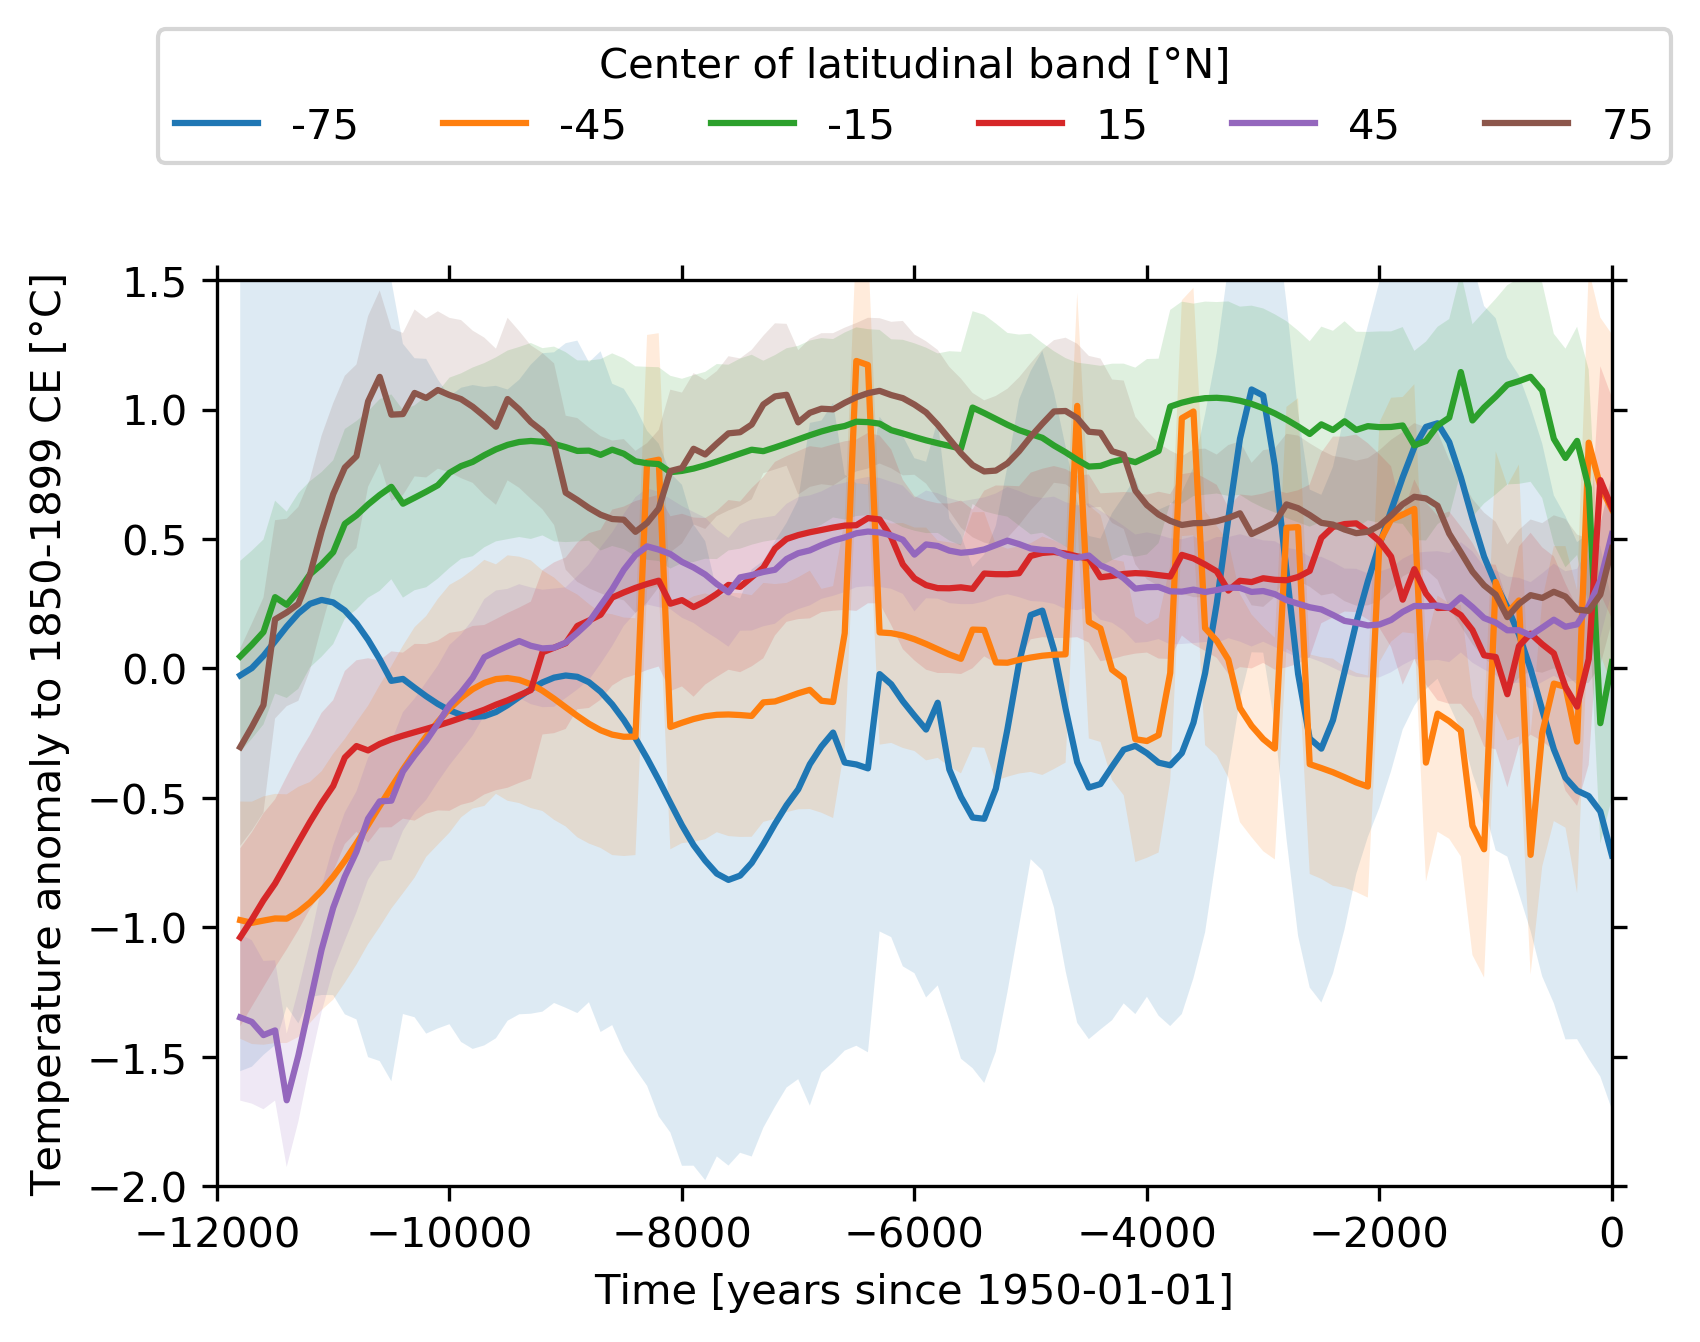

In [47]:
sp = bands.psy.plot.lineplot(
    name=[[['temperature', 'temperature_std']]],
    lat=list(range(6)), legendlabels='%(lat)s',
    xlabel='Time [years since 1950-01-01]',
    ylabel='Temperature anomaly to 1850-1899 CE [°C]',
    xlim='minmax', 
    legend=dict(loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.3),
                title='Center of latitudinal band [°N]'))

plt.gcf().set_dpi(300)

Compute the samples per band that have been used. There is an nsamples variable already in the file, but this one is based on the entire ensemble.

In [48]:
nsamples = ensemble.input_data.age.groupby_bins('lat', range(-90, 91, 30)).apply(
    lambda da: da.groupby_bins(da, np.arange(-50, 12051, 100)).apply(
        lambda da: xr.DataArray(np.unique(da.TSid).size)))
nsamples['lat_bins'] = ('lat_bins', [i.mid for i in nsamples.lat_bins.values])
nsamples['age_bins'] = ('age_bins', [i.mid for i in nsamples.age_bins.values])

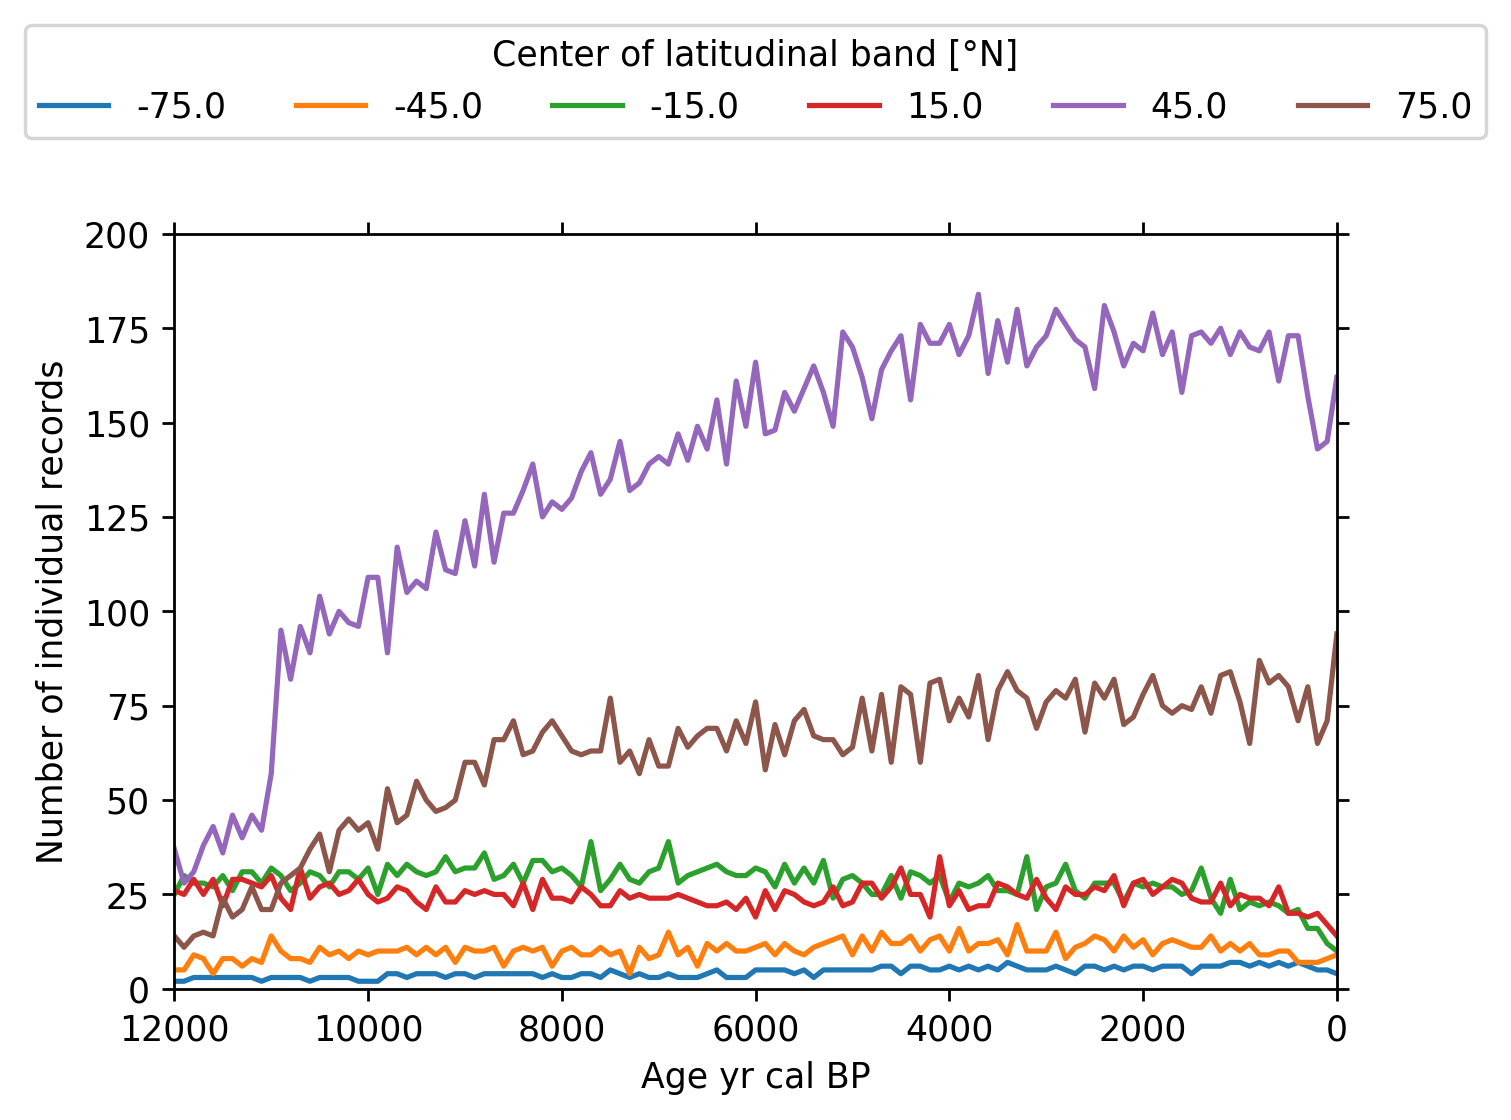

In [49]:
nsamples.to_dataset(name='nsamples').psy.plot.lineplot(
    lat_bins=list(range(6)), legendlabels='%(lat_bins)s',
    ylabel='Number of individual records', xlabel='Age yr cal BP',
    xlim='minmax', 
    legend=dict(loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.3),
                    title='Center of latitudinal band [°N]'))
plt.gcf().set_dpi(250)
plt.gca().invert_xaxis()

In [50]:
bands = bands.rename({'nsamples': 'nsamples_ens'})
bands['nsamples'] = nsamples.rename({'lat_bins': 'lat', 'age_bins': 'age'})

## Compute global mean

In [51]:
with warnings.catch_warnings() as c:
    warnings.filterwarnings('ignore', '\s*Mean of empty slice')
    glob_mean = output.mean('cell')

    # compute the sum for the number of samples and the cell_area
    glob_mean['nsamples'] = output.nsamples.sum('cell')
    glob_mean['cell_area'] = output.cell_area.sum('cell')

In [52]:
glob_mean['temperature_std'] = glob_mean.temperature_samples.std('ens')

/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


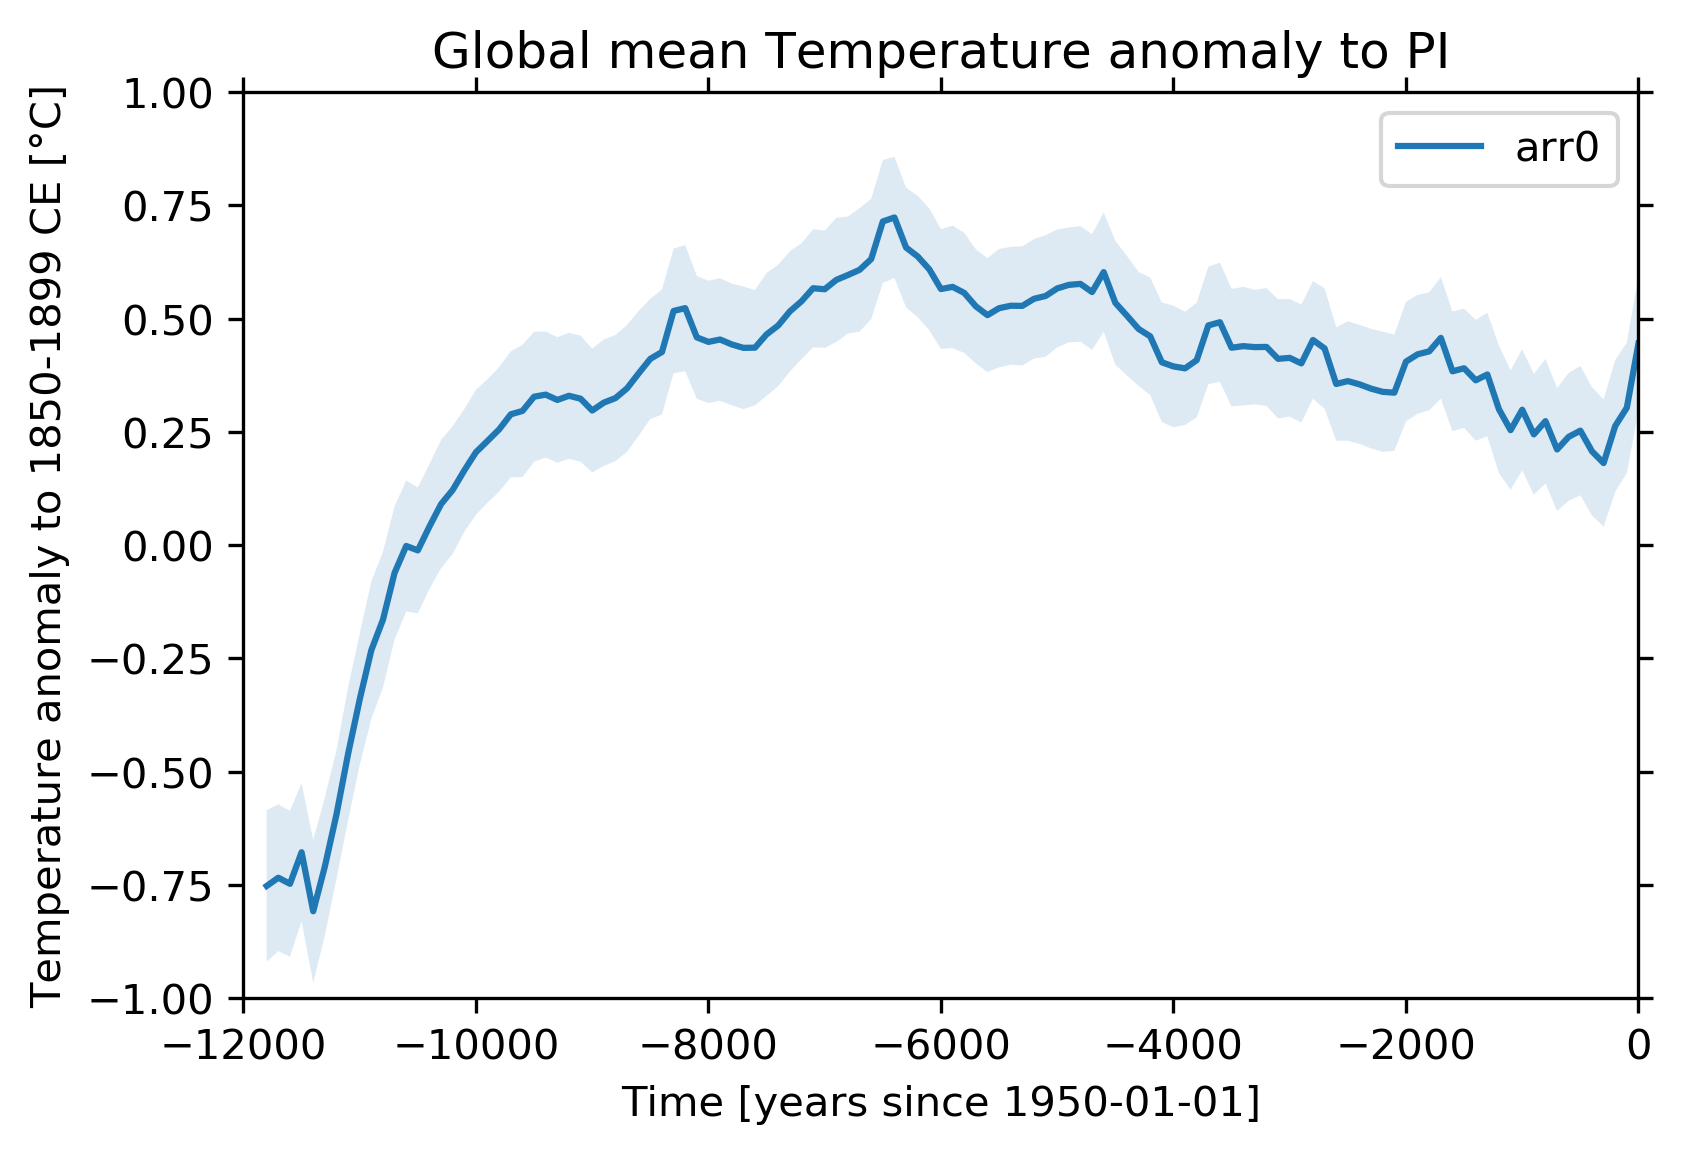

In [53]:
sp = glob_mean.psy.plot.lineplot(
    name=[[['temperature', 'temperature_std']]],
    title='Global mean Temperature anomaly to PI',
    xlabel='Time [years since 1950-01-01]',
    ylabel='Temperature anomaly to 1850-1899 CE [°C]',
    xlim='minmax')

plt.gcf().set_dpi(300)

## Export CSV file

In [54]:
out_df = output.drop_dims(['ens', 'bnds']).to_dataframe().dropna(subset=['temperature'])
out_df.reset_index(inplace=True)
out_df.set_index(['clon', 'clat'], inplace=True)

in_df = ensemble.input_data.drop_dims('ens').to_dataframe().drop_duplicates('TSid')
in_df.reset_index(inplace=True)
in_df.set_index(['clon', 'clat'], inplace=True)
del in_df['age'], in_df['temperature']

# add link to lipdverse
lipdverse_uri = f'http://lipdverse.org/globalHolocene/{db_version}/'
in_df['lipdverse'] = lipdverse_uri + in_df.dataSetName + '.html'

out_df = out_df.join(in_df, how='right').dropna(subset=['temperature'])

Merge pi anomaly

In [55]:
out_df.reset_index(inplace=True)
out_df.sort_values(['clon', 'clat', 'TSid', 'time'], inplace=True)
out_df.set_index(['clon', 'clat'], inplace=True)

In [56]:
out_df[out_df.tavg_missing].drop_duplicates(['TSid']).to_excel(f'{output_dir}/missing_climate.xlsx')

In [57]:
clat = out_df.reset_index('clat').clat
out_df['band'] = np.asarray(clat - (clat % 30) + 15)
for band, group in out_df.groupby('band'):
    group.to_csv(f'{output_dir}/{key}-{band:1.0f}degN.tsv', '\t')